<a href="https://colab.research.google.com/github/AilingLiu/Survival_analysis/blob/master/check_assumptions_of_cox_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5)
%matplotlib inline

In [0]:
!pip install lifelines

In [0]:
data_link = 'https://raw.githubusercontent.com/AilingLiu/Survival_analysis/master/Data/simulated%20HF%20mort%20data%20for%20GMPH%20(1K)%20final.csv'


hf = pd.read_csv(data_link, index_col='id')
hf.head()

,death,los,age,gender,cancer,cabg,crt,defib,dementia,diabetes,hypertension,ihd,mental_health,arrhythmias,copd,obesity,pvd,renal_disease,valvular_disease,metastatic_cancer,pacemaker,pneumonia,prior_appts_attended,prior_dnas,pci,stroke,senile,quintile,ethnicgroup,fu_time
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,2,90,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,4,0,0,0,0,2.0,NaN,416
2,0,10,74,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,9,1,0,0,0,4.0,1.0,648
3,0,3,83,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3.0,1.0,466
4,0,1,79,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0,9,2,1,1,0,5.0,1.0,441
5,0,17,94,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,2.0,1.0,371


In [0]:
# one hot encoding
var = 'age, gender, copd'.replace(' ', '').split(',') + ['fu_time', 'death']
hf.loc[:, 'ethnicgroup'].fillna(value=8, inplace=True)
hf.dropna(subset=['quintile'], inplace=True)

df = hf.loc[hf.quintile !=0, :]
quintile = pd.get_dummies(df['quintile'], prefix='quintile', drop_first=True)
ethnic = pd.get_dummies(df['ethnicgroup'], prefix='ethnic', drop_first=True)

ndf = pd.concat([ethnic, quintile, df.loc[:, var]], axis=1)


In [43]:
from lifelines import CoxPHFitter
cox = CoxPHFitter()

model = cox.fit(ndf, 'fu_time', 'death')
model.print_summary(model="Model 1")

## Check assumptions

Again, we can use the `check_assumptions` function from `lifeline` modules, which used `scaled Schoenfeld residuals` to test the independence of residuals and time.

In [0]:
model.check_assumptions(ndf, p_value_threshold=0.05, show_plots=True)

Proportional hazard assumption looks okay.


Interestingly, the `check_assumptions` function in lifeline model does not output plots if the assumption is satisfied. So, let's conduct a due deligence check using its `proportional_hazard_test` function.

In [0]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(model, ndf, time_transform='rank')
results.print_summary(decimals=3, model="model 1")

The pvalue for each predictor is above .05, there is no strong evidence between the residuals and time. The model has correctly handled the relation between each predictor and time so that there's nothing left of that relation for the residuals to spot. 

If we have only one categorical predictor with two levels, such as gender, we can use Kaplan-Meier plot as an informal visual check on proportional assumption. If the predictor satisfies the proportional hazard assumption, then the graph of the survival function versus the survival time should yield parallel curves. This method does not work well for continuous predictors or categorical ones with many levels because the graph becomes too “cluttered”.

Alternatively, R has quite good plots to check assumption. Check out the R file I created in the same repository to visulize the Schoenfeld Residuals of Gender Against Time. 

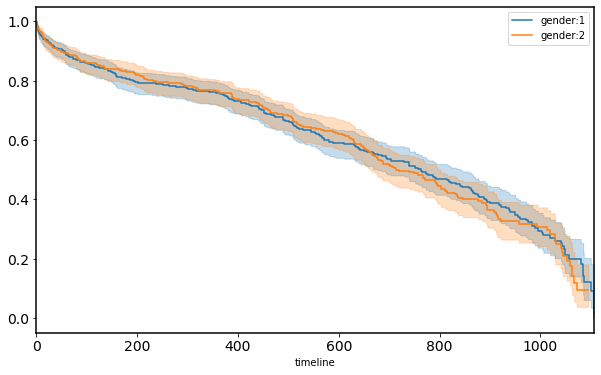

In [40]:
from lifelines import KaplanMeierFitter
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

kmf = KaplanMeierFitter()
df = hf.loc[:, ['fu_time', 'death', 'gender']]

for name, grouped_df in df.groupby('gender'):
    kmf.fit(grouped_df["fu_time"], grouped_df["death"], label='gender:'+str(name))
    kmf.plot(ax=ax)

Use Martingale residuls to assess proportionality assumption

In [44]:
r = model.compute_residuals(ndf, 'martingale')
r.head()

,fu_time,death,martingale
id,,,
38,0.0,False,-0.000920
484,0.0,False,-0.000162
535,0.0,False,-0.003109
550,0.0,False,-0.000787
964,0.0,False,-0.003942


Positive values mean that the patient died sooner than expected (according to the model); negative values mean that the patient lived longer than expected (or were censored).